In [3]:
# Some parts of this code are based on the Python script:
# https://github.com/pytorch/tutorials/blob/master/beginner_source/transfer_learning_tutorial.py
# License: BSD

import time
import os
import copy

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms

# Install Pennylane if not already installed
!pip install pennylane

# Pennylane
import pennylane as qml
from pennylane import numpy as np

torch.manual_seed(42)
np.random.seed(42)

# Plotting
import matplotlib.pyplot as plt

# OpenMP: number of parallel threads.
os.environ["OMP_NUM_THREADS"] = "1"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 113.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 935.6/935.6 kB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 111.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 117.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 100.2 MB/s eta 0:00:00


In [4]:
n_qubits = 4                # Number of qubits
step = 0.001               # Learning rate
batch_size = 16              # Number of samples for each training step
num_epochs = 50             # Number of training epochs
q_depth = 4                 # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.01              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer

In [5]:
dev = qml.device("default.qubit", wires=n_qubits)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [20]:
data_transforms = {
    "train": transforms.Compose(
        [
            # transforms.RandomResizedCrop(224),     # uncomment for data augmentation
            # transforms.RandomHorizontalFlip(),     # uncomment for data augmentation
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            # Normalize input channels using mean values and standard deviations of ImageNet.
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

# Original zip file path
zip_file_path = "/content/New_braintumor.zip"
# Directory where the zip file will be extracted
extracted_dir = "/content/OnlyNew/New_braintumor"

# Extract the zip file if it hasn't been extracted already
if not os.path.exists(extracted_dir):
    import zipfile
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_dir)

# Update data_dir to point to the extracted directory
data_dir = extracted_dir

image_datasets = {
    x if x == "train" else "validation": datasets.ImageFolder(
        os.path.join(data_dir, x), data_transforms[x]
    )
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "validation"]}
class_names = image_datasets["train"].classes

# Initialize dataloader
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

# function to plot images
def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # Inverse of the initial normalization operation.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

# Display the directory structure to identify the correct path
print(f"Contents of {extracted_dir}:")
!ls -R "{extracted_dir}"


Contents of /content/OnlyNew/New_braintumor:
/content/OnlyNew/New_braintumor:
train  val

/content/OnlyNew/New_braintumor/train:
no  yes

/content/OnlyNew/New_braintumor/train/no:
no0.jpg     no1192.jpg	no1391.jpg  no239.jpg  no433.jpg  no619.jpg  no812.jpg
no1001.jpg  no1193.jpg	no1392.jpg  no240.jpg  no434.jpg  no620.jpg  no813.jpg
no1004.jpg  no1194.jpg	no1395.jpg  no241.jpg  no435.jpg  no621.jpg  no814.jpg
no1005.jpg  no1197.jpg	no1396.jpg  no243.jpg  no436.jpg  no622.jpg  no815.jpg
no1007.jpg  no1198.jpg	no1397.jpg  no244.jpg  no437.jpg  no623.jpg  no816.jpg
no1008.jpg  no1199.jpg	no139.jpg   no245.jpg  no438.jpg  no625.jpg  no818.jpg
no1009.jpg  no119.jpg	No13.jpg    no247.jpg  no439.jpg  no627.jpg  no819.jpg
no100.jpg   no11.jpg	no1401.jpg  no248.jpg  no43.jpg   no628.jpg  no81.jpg
no1010.jpg  no1200.jpg	no1402.jpg  no249.jpg  no440.jpg  no62.jpg   no820.jpg
no1011.jpg  no1201.jpg	no1403.jpg  no24.jpg   no441.jpg  no630.jpg  no821.jpg
no1012.jpg  no1202.jpg	no1404.jpg  no250.jpg

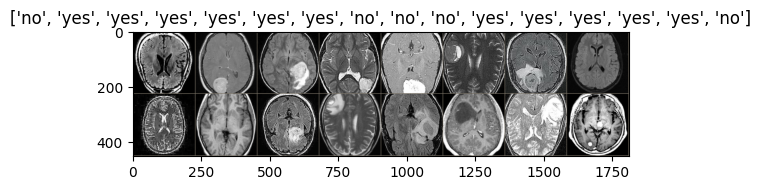

In [21]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders["validation"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

In [22]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

In [23]:
@qml.qnode(dev)
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

In [24]:
class DressedQuantumNet(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()
        self.pre_net = nn.Linear(2048, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, 2)

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 4
        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = torch.hstack(quantum_net(elem, self.q_params)).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)

In [25]:
weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V1
model_hybrid = torchvision.models.resnet50(weights=weights)

for param in model_hybrid.parameters():
    param.requires_grad = False


# Notice that model_hybrid.fc is the last layer of ResNet18
model_hybrid.fc = DressedQuantumNet()

# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 232MB/s]


In [26]:
criterion = nn.CrossEntropyLoss()


In [27]:
optimizer_hybrid = optim.AdamW(model_hybrid.fc.parameters(), lr=step, weight_decay=1e-4)

In [28]:
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler
)

In [31]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 10000.0  # Large arbitrary number
    best_acc_train = 0.0
    best_loss_train = 10000.0  # Large arbitrary number
    print("Training started:")

    for epoch in range(num_epochs):

        # Each epoch has a training and validation phase
        for phase in ["train", "validation"]:
            if phase == "train":
                # Set model to training mode
                model.train()
            else:
                # Set model to evaluate mode
                model.eval()
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            n_batches = dataset_sizes[phase] // batch_size
            it = 0
            for inputs, labels in dataloaders[phase]:
                since_batch = time.time()
                batch_size_ = len(inputs)
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                # Track/compute gradient and make an optimization step only when training
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Print iteration results
                running_loss += loss.item() * batch_size_
                batch_corrects = torch.sum(preds == labels.data).item()
                running_corrects += batch_corrects
                print(
                    "Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}".format(
                        phase,
                        epoch + 1,
                        num_epochs,
                        it + 1,
                        n_batches + 1,
                        time.time() - since_batch,
                    ),
                    end="\r",
                    flush=True,
                )
                it += 1

            # Print epoch results
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            print(
                "Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}        ".format(
                    "train" if phase == "train" else "validation  ",
                    epoch + 1,
                    num_epochs,
                    epoch_loss,
                    epoch_acc,
                )
            )

            # Check if this is the best model wrt previous epochs
            if phase == "validation" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'best_model.pth') # Save the best model weights
            if phase == "validation" and epoch_loss < best_loss:
                best_loss = epoch_loss
            if phase == "train" and epoch_acc > best_acc_train:
                best_acc_train = epoch_acc
            if phase == "train" and epoch_loss < best_loss_train:
                best_loss_train = epoch_loss

            # Update learning rate
            if phase == "train":
                scheduler.step()

    # Print final results
    model.load_state_dict(best_model_wts)
    time_elapsed = time.time() - since
    print(
        "Training completed in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60)
    )
    print("Best train accuracy: {:.4f}".format(best_acc_train))
    print("Best test loss: {:.4f} | Best test accuracy: {:.4f}".format(best_loss, best_acc))
    return model, time_elapsed, best_acc_train, best_acc, best_loss

In [32]:
model_hybrid, training_time, best_train_acc, best_val_acc, best_val_loss = train_model(
    model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=num_epochs
)

Training started:
Phase: train Epoch: 1/50 Loss: 0.1420 Acc: 0.9487        
Phase: validation   Epoch: 1/50 Loss: 0.1734 Acc: 0.9400        
Phase: train Epoch: 2/50 Loss: 0.1462 Acc: 0.9467        
Phase: validation   Epoch: 2/50 Loss: 0.1673 Acc: 0.9417        
Phase: train Epoch: 3/50 Loss: 0.1318 Acc: 0.9487        
Phase: validation   Epoch: 3/50 Loss: 0.1721 Acc: 0.9383        
Phase: train Epoch: 4/50 Loss: 0.1400 Acc: 0.9521        
Phase: validation   Epoch: 4/50 Loss: 0.1718 Acc: 0.9383        
Phase: train Epoch: 5/50 Loss: 0.1440 Acc: 0.9517        
Phase: validation   Epoch: 5/50 Loss: 0.1991 Acc: 0.9267        
Phase: train Epoch: 6/50 Loss: 0.1447 Acc: 0.9442        
Phase: validation   Epoch: 6/50 Loss: 0.1677 Acc: 0.9383        
Phase: train Epoch: 7/50 Loss: 0.1338 Acc: 0.9508        
Phase: validation   Epoch: 7/50 Loss: 0.1731 Acc: 0.9433        
Phase: train Epoch: 8/50 Loss: 0.1346 Acc: 0.9575        
Phase: validation   Epoch: 8/50 Loss: 0.1813 Acc: 0.9333       

In [33]:
total_params = sum(p.numel() for p in model_hybrid.parameters() if p.requires_grad)
print(f"Total trainable parameters in model_hybrid: {total_params}")

Total trainable parameters in model_hybrid: 8222


In [34]:
model_hybrid.eval()

inference_times = []
num_inference_samples = 100 # Using a subset for demonstration

with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders["validation"]):
        if i * batch_size >= num_inference_samples: # Break after processing enough samples
            break
        inputs = inputs.to(device)

        start_time = time.time()
        _ = model_hybrid(inputs)
        end_time = time.time()

        batch_time = end_time - start_time
        inference_times.extend([batch_time / len(inputs)] * len(inputs))

average_inference_time_per_image = sum(inference_times) / len(inference_times)
print(f"Average inference time per image: {average_inference_time_per_image:.6f} seconds")

Average inference time per image: 0.017862 seconds


In [35]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Ensure model is in evaluation mode
model_hybrid.eval()

# Initialize storage lists
y_true = []
y_pred = []
y_prob = []

# Disable gradient computation
with torch.no_grad():
    for inputs, labels in dataloaders["validation"]:  # Using validation dataloader
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_hybrid(inputs)
        _, preds = torch.max(outputs, 1)
        probs = torch.nn.functional.softmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())

# Convert lists to numpy arrays for sklearn metrics
y_true_np = np.array(y_true)
y_pred_np = np.array(y_pred)
y_prob_np = np.array(y_prob)

# For binary classification, we typically use probabilities of the positive class
# Assuming 'yes' is the positive class (index 1) and 'no' is the negative class (index 0)
# If there are more than two classes, this needs to be adapted for one-vs-rest or similar
if len(class_names) == 2:
    y_scores = y_prob_np[:, 1]  # Probabilities of the positive class ('yes')
    y_true_binary = (y_true_np == class_names.index('yes')).astype(int)

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true_binary, y_scores)

    # KS Curve (Kolmogorov-Smirnov)
    # Compute ROC curve for KS calculation
    fpr, tpr, thresholds = roc_curve(y_true_binary, y_scores)
    ks_statistic = np.max(tpr - fpr)
    ks_threshold_idx = np.argmax(tpr - fpr)
    ks_threshold = thresholds[ks_threshold_idx]

    print(f"KS Statistic: {ks_statistic:.4f}")
    print(f"KS Threshold: {ks_threshold:.4f}")

else:
    print("Precision-Recall and KS curves are primarily for binary classification.")
    print("Skipping for multi-class classification or if 'yes' class is not clear.")

KS Statistic: 0.9000
KS Threshold: 0.4871


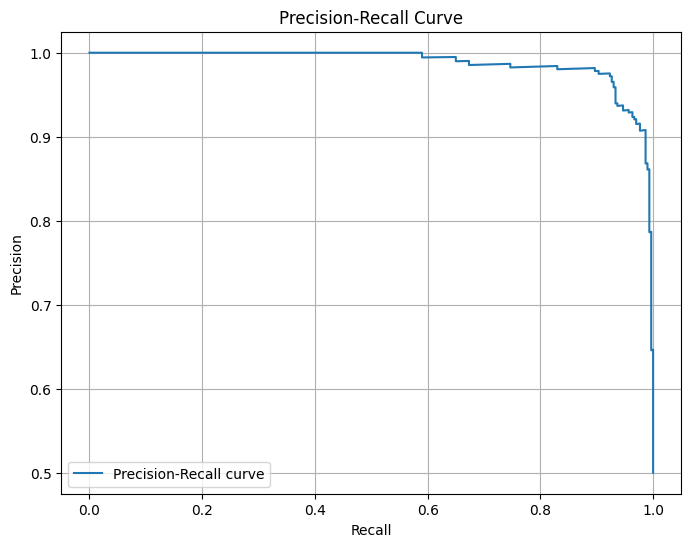

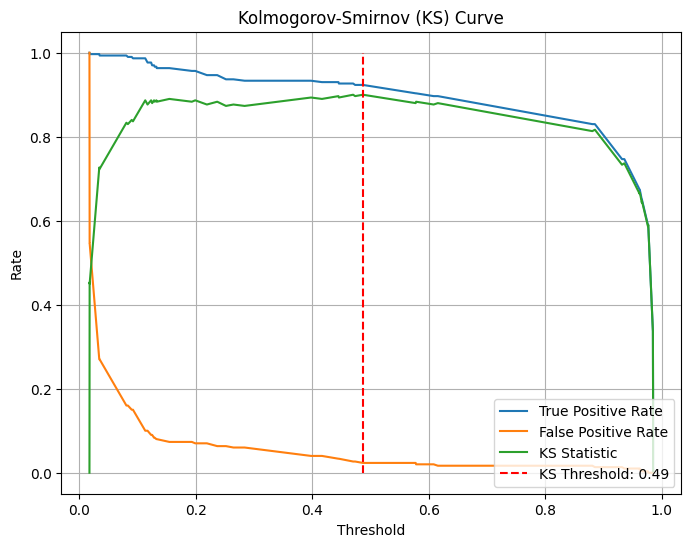

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

# Plotting KS Curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds, tpr, label='True Positive Rate')
plt.plot(thresholds, fpr, label='False Positive Rate')
plt.plot(thresholds, tpr - fpr, label='KS Statistic')
plt.vlines(x=ks_threshold, ymin=0, ymax=1, linestyle='--', color='red', label=f'KS Threshold: {ks_threshold:.2f}')
plt.title('Kolmogorov-Smirnov (KS) Curve')
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
